In [18]:
import yfinance as yf
import pandas as pd

# Define the ticker symbols
tickers = ['KO', 'PEP']

# Fetch historical data
data = yf.download(tickers, start='2019-01-01')['Close']

# Drop rows with missing values
data.dropna(inplace=True)

# Display the first few rows
print(data.head())

[*********************100%***********************]  2 of 2 completed

Ticker             KO        PEP
Date                            
2019-01-02  38.672173  91.114998
2019-01-03  38.433205  90.264549
2019-01-04  39.199547  92.115532
2019-01-07  38.688641  91.323441
2019-01-08  39.125378  92.198906


In [19]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Perform linear regression to find the hedge ratio
X = sm.add_constant(data['PEP'])
model = sm.OLS(data['KO'], X).fit()
hedge_ratio = model.params['PEP']

# Calculate the spread
data['Spread'] = data['KO'] - hedge_ratio * data['PEP']

# Conduct the Augmented Dickey-Fuller test on the spread
adf_result = adfuller(data['Spread'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: 1.1364326113636143
p-value: 0.9955158741243402


In [20]:
import numpy as np

# Calculate the rolling mean and standard deviation
window = 30
data['Mean'] = data['Spread'].rolling(window=window).mean()
data['Std'] = data['Spread'].rolling(window=window).std()

# Compute the Z-score
data['Z-score'] = (data['Spread'] - data['Mean']) / data['Std']

# Define trading signals
entry_threshold = 1.0
exit_threshold = 0.0

# Initialize positions
data['Long'] = (data['Z-score'] < -entry_threshold).astype(int)
data['Short'] = (data['Z-score'] > entry_threshold).astype(int)
data['Exit'] = (abs(data['Z-score']) < exit_threshold).astype(int)

# Determine positions
data['Position'] = 0
data.loc[data['Long'] == 1, 'Position'] = 1
data.loc[data['Short'] == 1, 'Position'] = -1
data.loc[data['Exit'] == 1, 'Position'] = 0

# Forward fill positions
data['Position'] = data['Position'].replace(to_replace=0, method='ffill')


/tmp/ipykernel_27808/2298204197.py:27: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['Position'] = data['Position'].replace(to_replace=0, method='ffill')


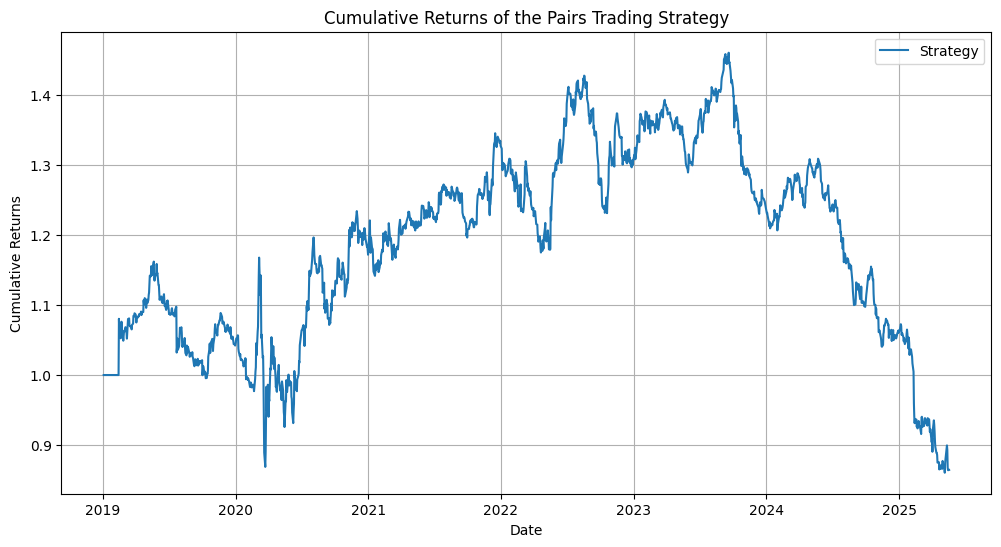

In [21]:
# Calculate daily returns
data['KO_Return'] = data['KO'].pct_change()
data['PEP_Return'] = data['PEP'].pct_change()

# Strategy returns
data['Strategy_Return'] = data['Position'].shift(1) * (data['KO_Return'] - hedge_ratio * data['PEP_Return'])

# Cumulative returns
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()

# Plot the cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Strategy_Return'], label='Strategy')
plt.title('Cumulative Returns of the Pairs Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


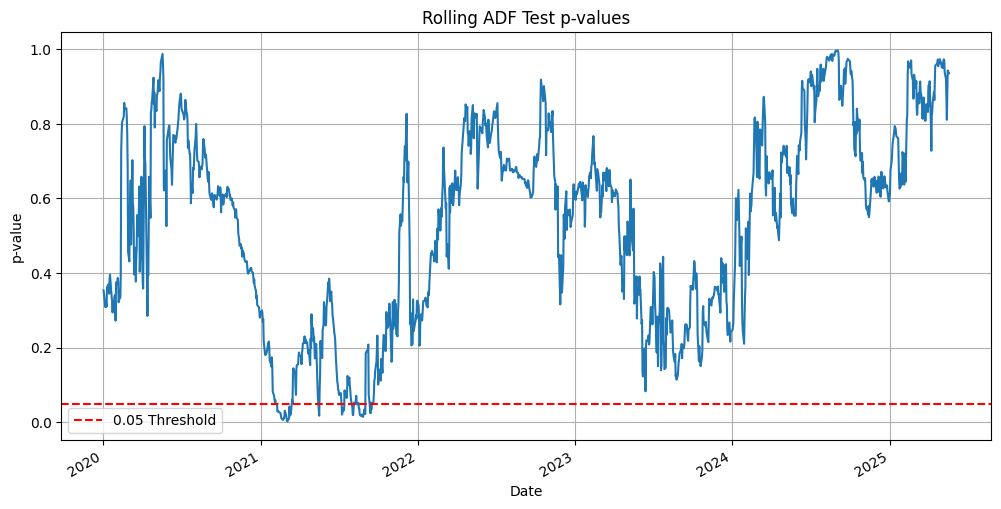

In [23]:
from statsmodels.tsa.stattools import adfuller

# Define rolling window size
rolling_window = 252  # Approximately one trading year

# Initialize list to store p-values
p_values = []

# Perform rolling ADF test
for i in range(rolling_window, len(data)):
    spread_series = data['Spread'].iloc[i - rolling_window:i]
    adf_result = adfuller(spread_series)
    p_values.append(adf_result[1])

# Create a DataFrame for p-values
p_values_df = pd.Series(p_values, index=data.index[rolling_window:])

# Plot the rolling p-values
plt.figure(figsize=(12, 6))
p_values_df.plot()
plt.axhline(y=0.05, color='r', linestyle='--', label='0.05 Threshold')
plt.title('Rolling ADF Test p-values')
plt.xlabel('Date')
plt.ylabel('p-value')
plt.legend()
plt.grid(True)
plt.show()


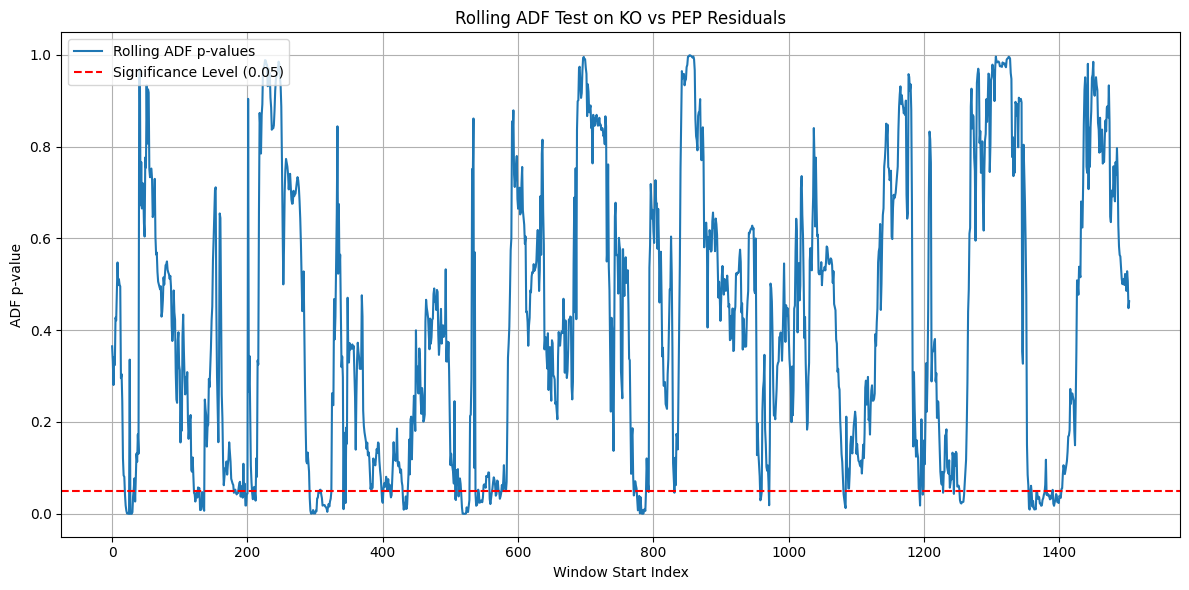

In [24]:
# Rolling ADF test
window_size = 100
rolling_adf_pvalues = []

for start in range(len(data) - window_size):
    end = start + window_size
    X = sm.add_constant(data["PEP"].iloc[start:end])
    y = data["KO"].iloc[start:end]
    model = sm.OLS(y, X).fit()
    residuals = y - model.predict(X)
    
    adf_result = adfuller(residuals)
    rolling_adf_pvalues.append(adf_result[1])

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(range(len(rolling_adf_pvalues)), rolling_adf_pvalues, label="Rolling ADF p-values")
plt.axhline(0.05, color='r', linestyle='--', label="Significance Level (0.05)")
plt.title("Rolling ADF Test on KO vs PEP Residuals")
plt.xlabel("Window Start Index")
plt.ylabel("ADF p-value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
r = pd.Series(rolling_adf_pvalues)
len(r[r < 0.05])

207